# Bike Sharing Demand

Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world.

The data generated by these systems makes them attractive for researchers because the duration of travel, departure location, arrival location, and time elapsed is explicitly recorded. Bike sharing systems therefore function as a sensor network, which can be used for studying mobility in a city. In this competition, participants are asked to combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C.

* ## Data Fields

datetime - hourly date + timestamp  

season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 

holiday - whether the day is considered a holiday

workingday - whether the day is neither a weekend nor holiday

weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy , 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ,3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds, 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
temp - temperature in Celsius

atemp - "feels like" temperature in Celsius

humidity - relative humidity

windspeed - wind speed

casual - number of non-registered user rentals initiated

registered - number of registered user rentals initiated

count - number of total rentals

### <a id='0'><strong>Notebook List.</strong></a>

#### 1.  <a href='#1'><strong>Data Load & Check</strong></a>
####      - Data load
####      - Outlier Check
####      - Check nan data 
####      - Check duplicated data

#### 2.  <a href='#2'><strong>EDA</strong></a>   
####      - Check Statistics
####      - Data Visulization
#### 3.  <a href='#3'><strong>Feature Engineering</strong></a>
####      - Search for valid columns
####      - Data Preprocessing

#### 4.  <a href='#4'><strong>Modeling & make submission</strong></a>
####      - Model: RandomForest and LightGBM
####      - Submission

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/bike-sharing-demand/train.csv
/kaggle/input/bike-sharing-demand/sampleSubmission.csv
/kaggle/input/bike-sharing-demand/test.csv


# <a id='1'><strong>Data Load & Check<strong></a>

In [2]:
test = pd.read_csv("/kaggle/input/bike-sharing-demand/test.csv",parse_dates=["datetime"])

In [3]:
# 날짜 칼럼은 판다스 datetiem형식으로 불러옴
train = pd.read_csv("/kaggle/input/bike-sharing-demand/train.csv",parse_dates=["datetime"])
#train["datetime"].astype("datetime64")
#pd.to_datetime(train["datetime"])
display(train.head(),test.head())

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [4]:
train["hour"]= train["datetime"].dt.hour
train["year"]= train["datetime"].dt.year
train["month"]= train["datetime"].dt.month
train["day"]= train["datetime"].dt.day
train["weekday"] = train["datetime"].dt.weekday

In [5]:
test["hour"]=test["datetime"].dt.hour
test["year"]= test["datetime"].dt.year
test["month"]= test["datetime"].dt.month
test["day"]= test["datetime"].dt.day
test["weekday"] = test["datetime"].dt.weekday

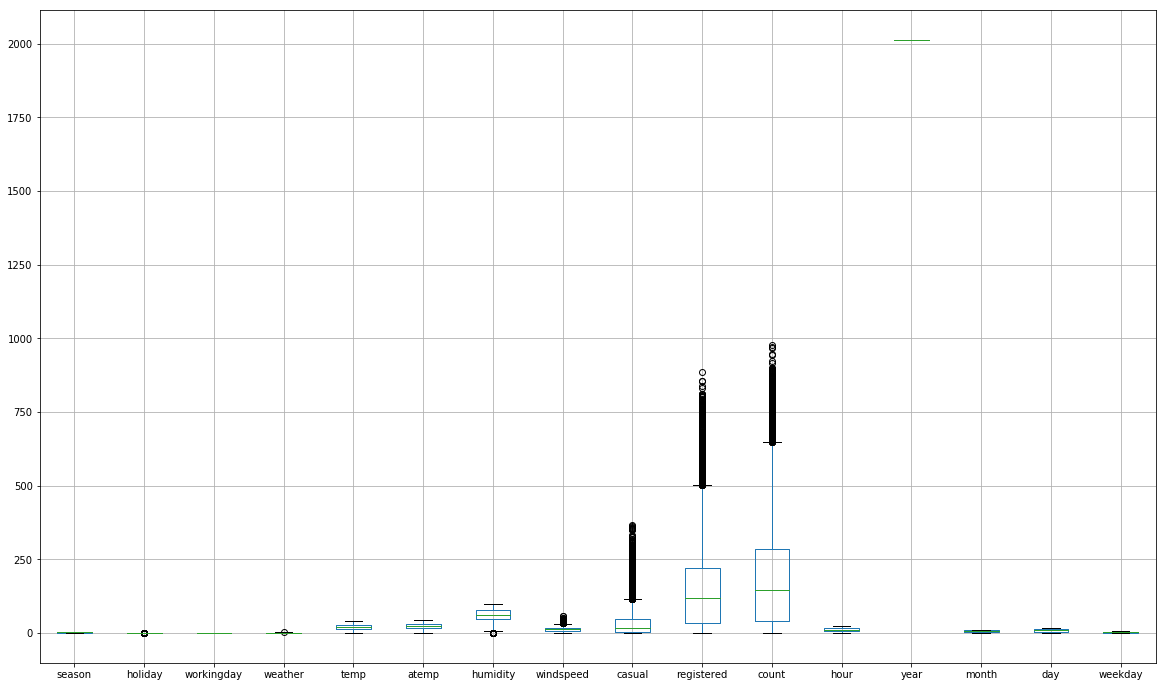

In [6]:
#Outlier Visualization
plt.figure(figsize=(20,12))
train.boxplot()

In [7]:
#Data overview and check nan
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 17 columns):
datetime      10886 non-null datetime64[ns]
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
hour          10886 non-null int64
year          10886 non-null int64
month         10886 non-null int64
day           10886 non-null int64
weekday       10886 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(13)
memory usage: 1.4 MB


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 14 columns):
datetime      6493 non-null datetime64[ns]
season        6493 non-null int64
holiday       6493 non-null int64
workingday    6493 non-null int64
weather       6493 non-null int64
temp          6493 non-null float64
atemp         6493 non-null float64
humidity      6493 non-null int64
windspeed     6493 non-null float64
hour          6493 non-null int64
year          6493 non-null int64
month         6493 non-null int64
day           6493 non-null int64
weekday       6493 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(10)
memory usage: 710.3 KB


In [9]:
#Check duplicated
sum(train.duplicated()), sum(test.duplicated())

(0, 0)

# <a id='2'><strong>EDA</strong></a>

### - Check Statistics

In [10]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,year,month,day,weekday
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,11.541613,2011.501929,6.521495,9.992559,3.013963
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,6.915838,0.500019,3.444373,5.476608,2.004585
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2011.000000,1.000000,1.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,6.000000,2011.000000,4.000000,5.000000,1.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,12.000000,2012.000000,7.000000,10.000000,3.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,18.000000,2012.000000,10.000000,15.000000,5.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,23.000000,2012.000000,12.000000,19.000000,6.000000


In [11]:
test.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,year,month,day,weekday
count,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000
mean,2.493300,0.029108,0.685815,1.436778,20.620607,24.012865,64.125212,12.631157,11.555367,2011.503619,6.565070,25.224550,3.007239
std,1.091258,0.168123,0.464226,0.648390,8.059583,8.782741,19.293391,8.250151,6.912526,0.500025,3.429462,3.339411,1.997714
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,16.000000,0.000000,0.000000,2011.000000,1.000000,20.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,49.000000,7.001500,6.000000,2011.000000,4.000000,22.000000,1.000000
50%,3.000000,0.000000,1.000000,1.000000,21.320000,25.000000,65.000000,11.001400,12.000000,2012.000000,7.000000,25.000000,3.000000
75%,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,81.000000,16.997900,18.000000,2012.000000,10.000000,28.000000,5.000000
max,4.000000,1.000000,1.000000,4.000000,40.180000,50.000000,100.000000,55.998600,23.000000,2012.000000,12.000000,31.000000,6.000000


In [12]:
train.groupby("year")["count"].mean()

year
2011    144.223349
2012    238.560944
Name: count, dtype: float64

In [13]:
train.groupby("weekday")["count"].mean()

weekday
0    190.390716
1    189.723847
2    188.411348
3    197.296201
4    197.844343
5    196.665404
6    180.839772
Name: count, dtype: float64

In [14]:
train.groupby("weekday")["count"].median()

weekday
0    146.0
1    146.0
2    136.0
3    155.0
4    167.0
5    141.5
6    119.0
Name: count, dtype: float64

In [15]:
train["weekday"].value_counts()

5    1584
6    1579
3    1553
2    1551
0    1551
1    1539
4    1529
Name: weekday, dtype: int64

### - Data Visualization

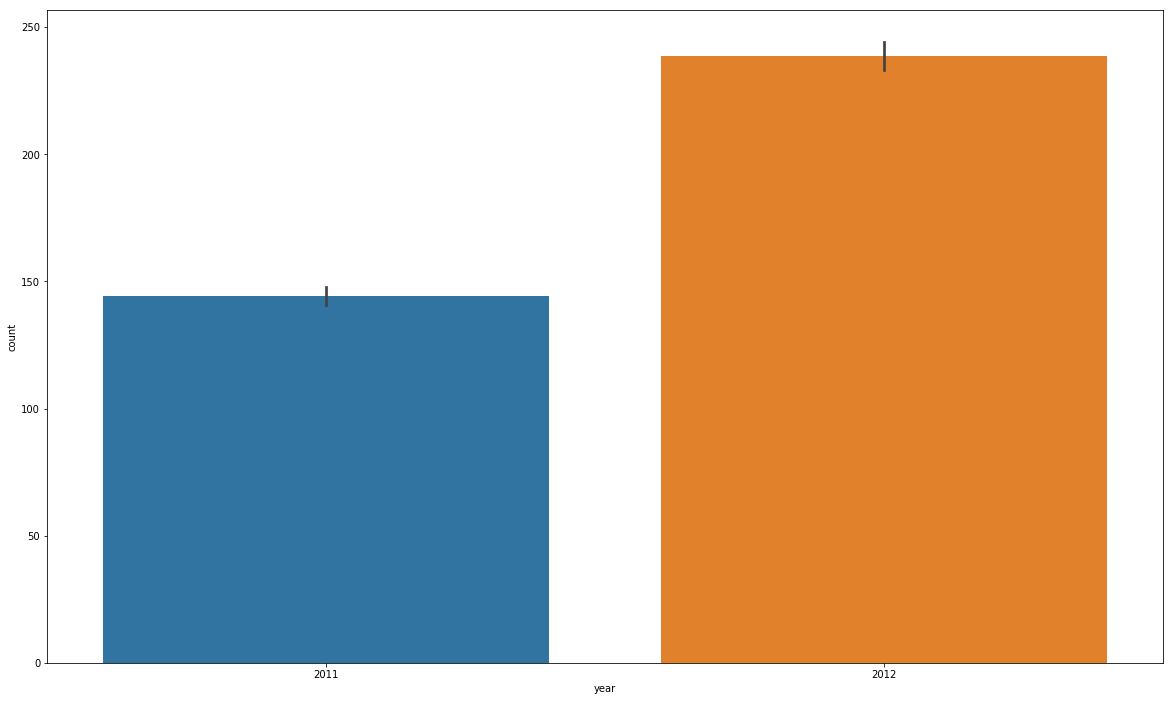

In [16]:
plt.figure(figsize=(20,12))
sns.barplot(train["year"],train["count"])

서비스가 막 시작된 2011년보다 2012년에 수요량이 더 많은 것을 확인할 수 있다.

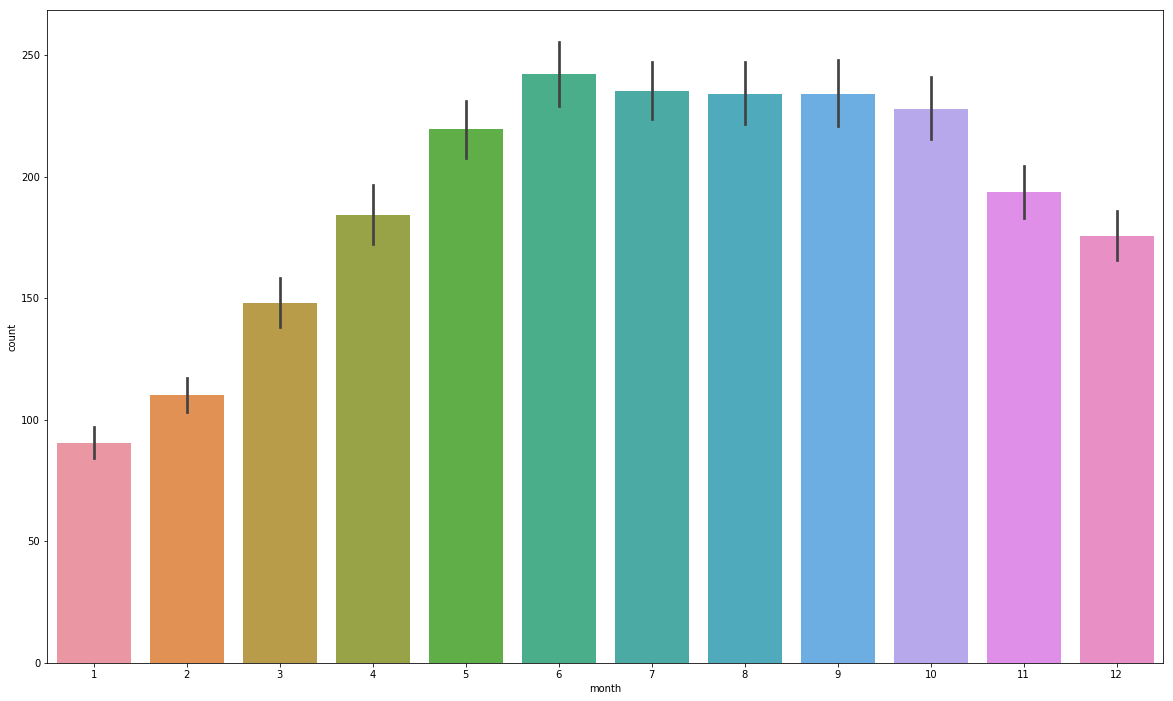

In [17]:
plt.figure(figsize=(20,12))
sns.barplot(train["month"],train["count"])

6월에 가장 수요량이 높고, 따뜻한 계절에 평균적으로 수요가 높다.

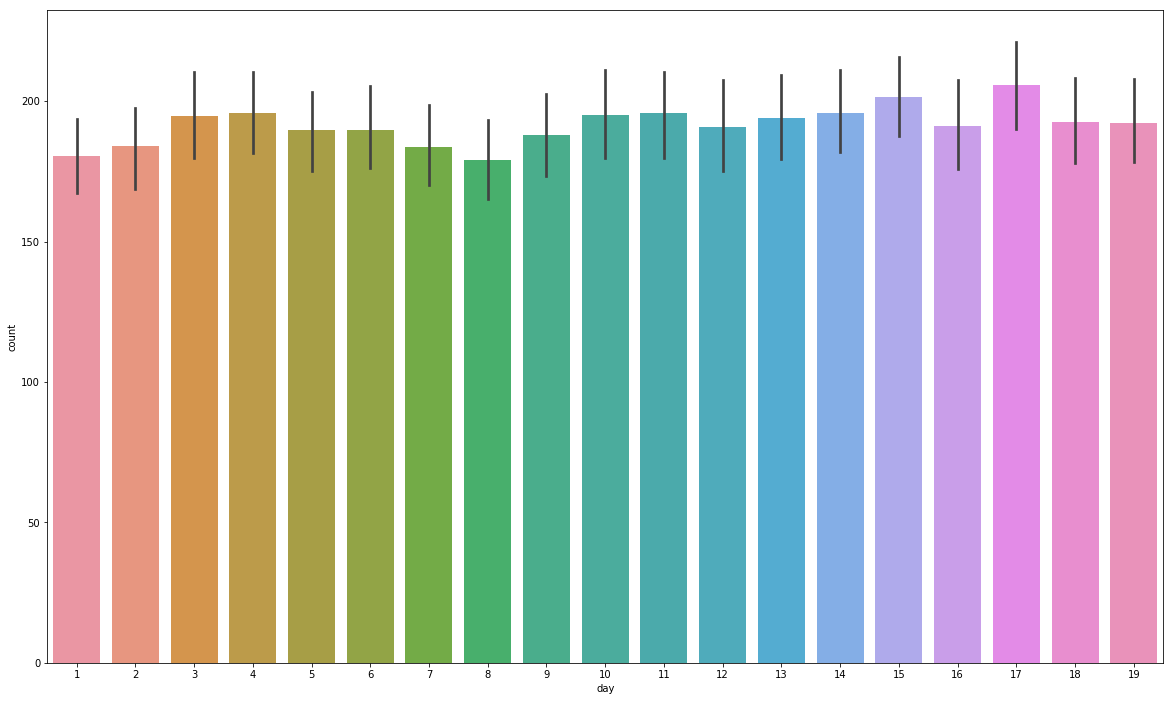

In [18]:
plt.figure(figsize=(20,12))
sns.barplot(train["day"],train["count"])

In [19]:
train["datetime"].describe()

count                   10886
unique                  10886
top       2011-06-09 04:00:00
freq                        1
first     2011-01-01 00:00:00
last      2012-12-19 23:00:00
Name: datetime, dtype: object

In [20]:
test["datetime"].describe()

count                    6493
unique                   6493
top       2011-09-21 10:00:00
freq                        1
first     2011-01-20 00:00:00
last      2012-12-31 23:00:00
Name: datetime, dtype: object

day 칼럼에는 1-19일 밖에 없는 문제가 있다. 그 이유를 확인해보니 train에 1-19일, test가 20-31일으로 나뉘어져 있었다.

1-19일의 데이터로 20-31일의 데이터를 맞추는 건 정확도에 영향을 끼칠 수 있으므로 day칼럼은 제거해야한다.

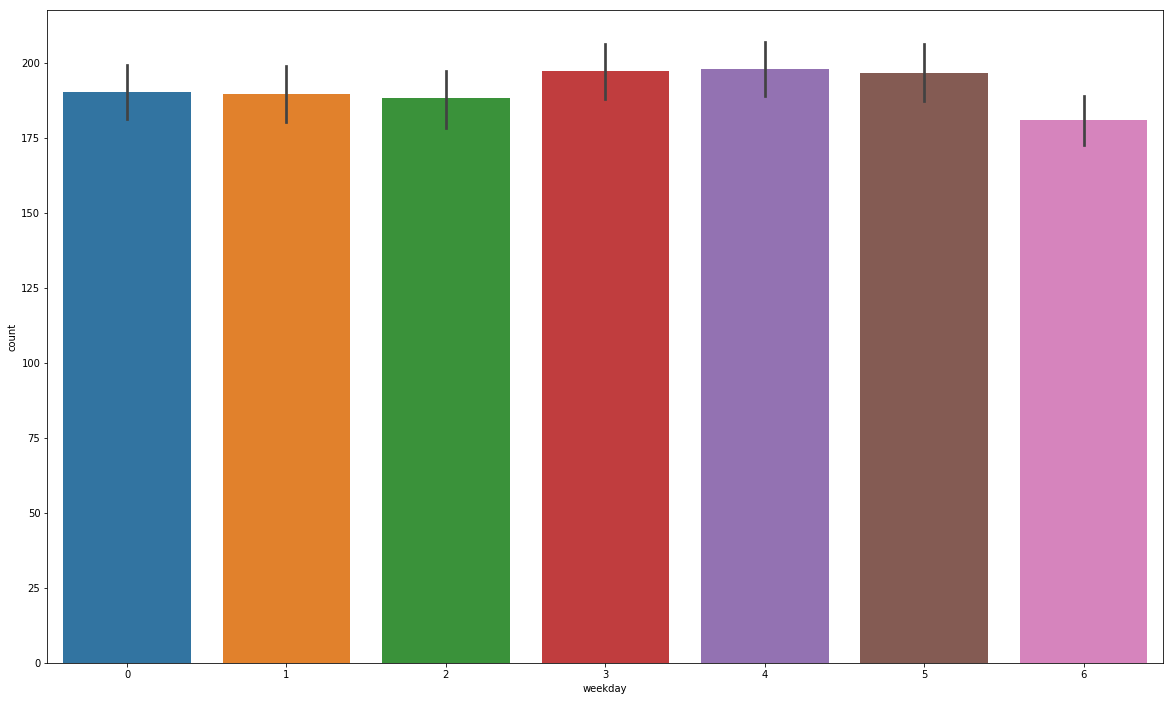

In [21]:
plt.figure(figsize=(20,12))
sns.barplot(train["weekday"],train["count"])

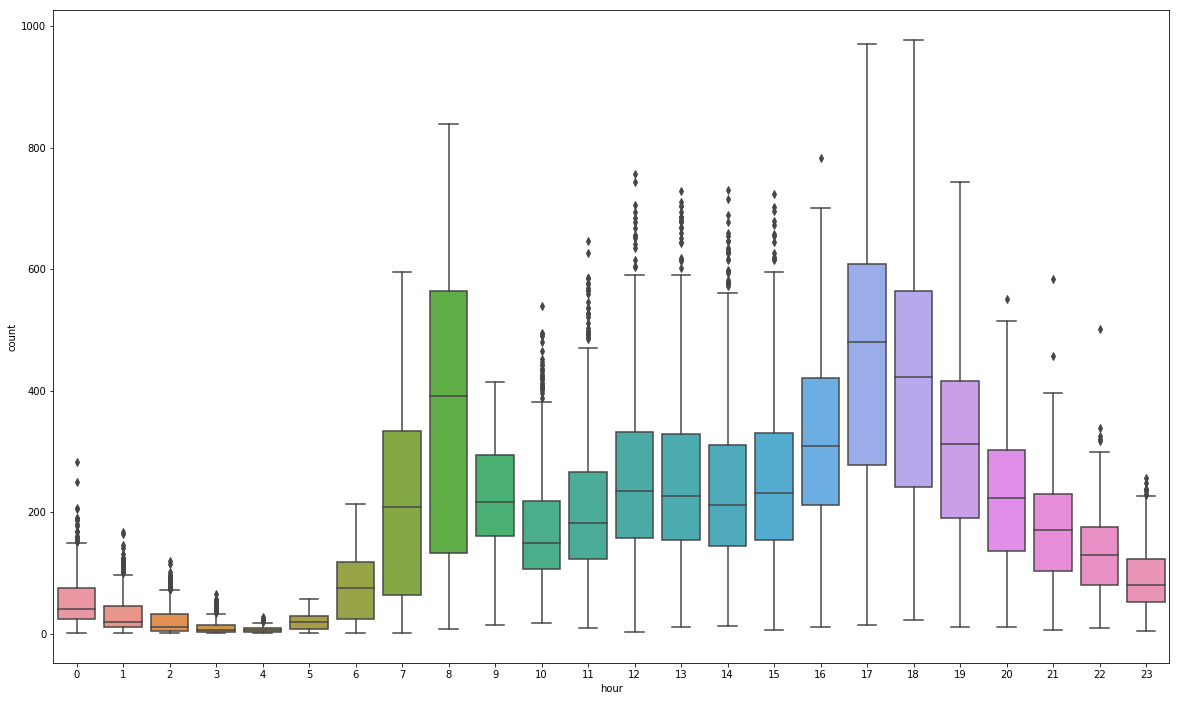

In [22]:
plt.figure(figsize=(20,12))
sns.boxplot(train["hour"],train["count"])

hour 칼럼은 boxplot의 outlier가 어떤 분포를 띄는 것을 볼 수 있다.

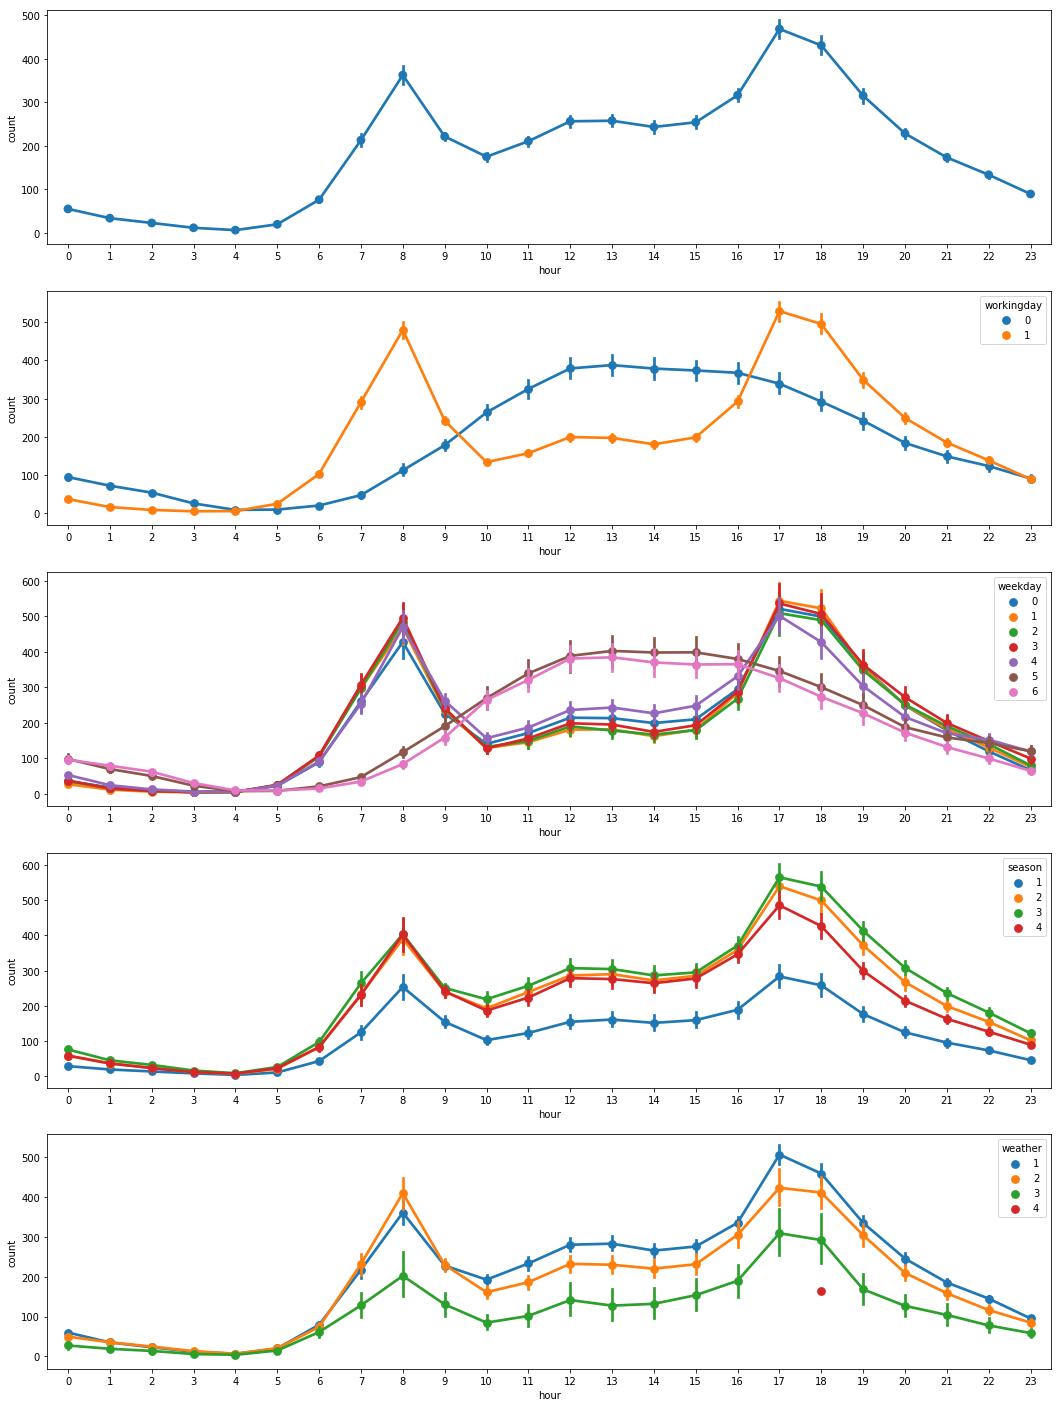

In [23]:
fig,(ax1, ax2, ax3, ax4, ax5)= plt.subplots(nrows=5)
fig.set_size_inches(18,25)

sns.pointplot(data=train, x='hour', y='count', ax=ax1)
sns.pointplot(data=train, x='hour', y='count', hue='workingday', ax=ax2)
sns.pointplot(data=train, x='hour', y='count', hue='weekday', ax=ax3)
sns.pointplot(data=train, x='hour', y='count', hue='season', ax=ax4)
sns.pointplot(data=train, x='hour', y='count', hue='weather', ax=ax5);

In [24]:
weekend = train[train["workingday"]==0]

In [25]:
weekday = train[train["workingday"]==1]

시간대에 여러 조건 칼럼들을 추가해 본 결과 주중, 주말의 차이가 아웃라이어의 분포와 비슷하다.

이를 검증하기 위해 데이터셋을 분리하여 확인.

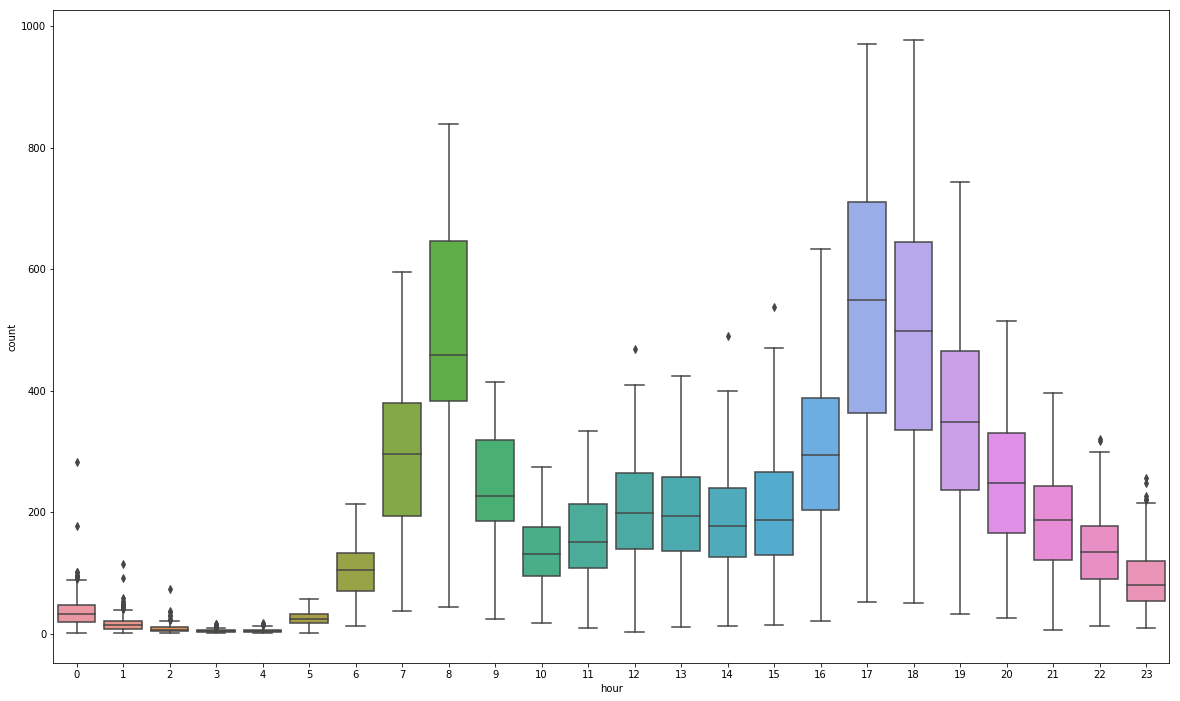

In [26]:
plt.figure(figsize=(20,12))
sns.boxplot(train["hour"],weekday["count"])

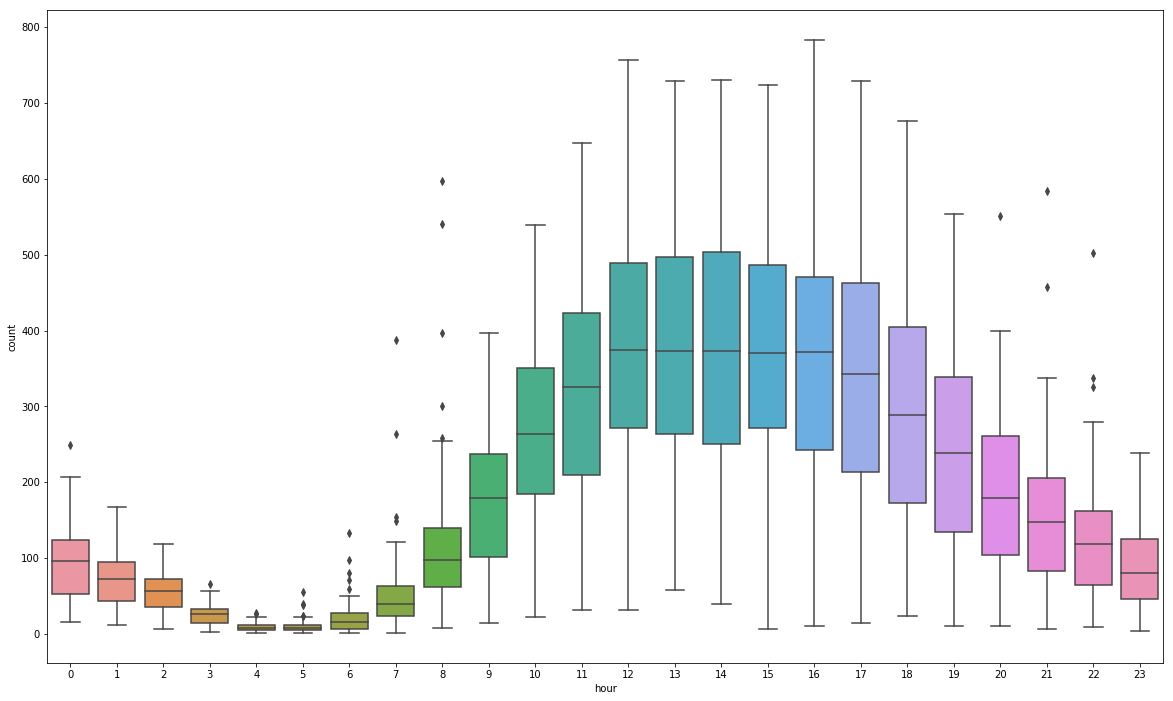

In [27]:
plt.figure(figsize=(20,12))
sns.boxplot(train["hour"],weekend["count"])

실제로 주말일경우와, 평일일 경우 시간에 따른 수요량 변화 분포가 다르다는 것을 알 수 있다.

평일에는 출퇴근 시간대에 수요량이 많고 주말에는 오후시간대에 전체적으로 수요량이 많아진다.

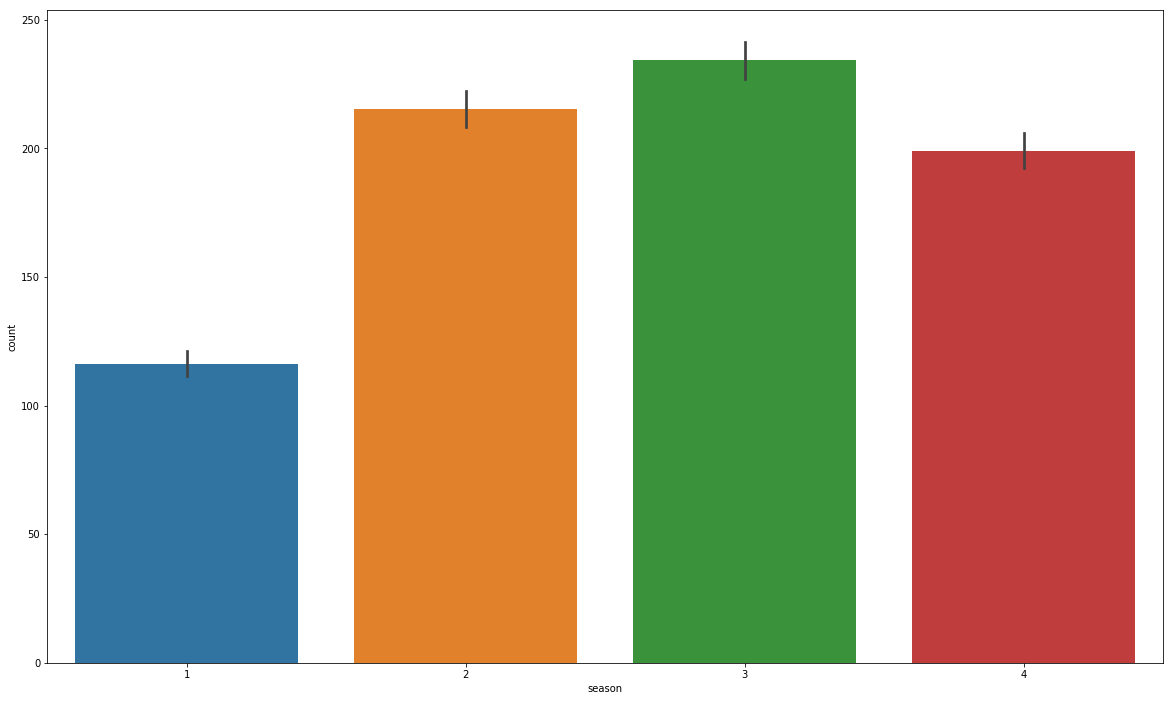

In [28]:
plt.figure(figsize=(20,12))
sns.barplot(train["season"],train["count"])

평균적으로 2,3 분기(따뜻한 계절)에 수요가 높다.

### - 온도, 습도, 풍속 시각화

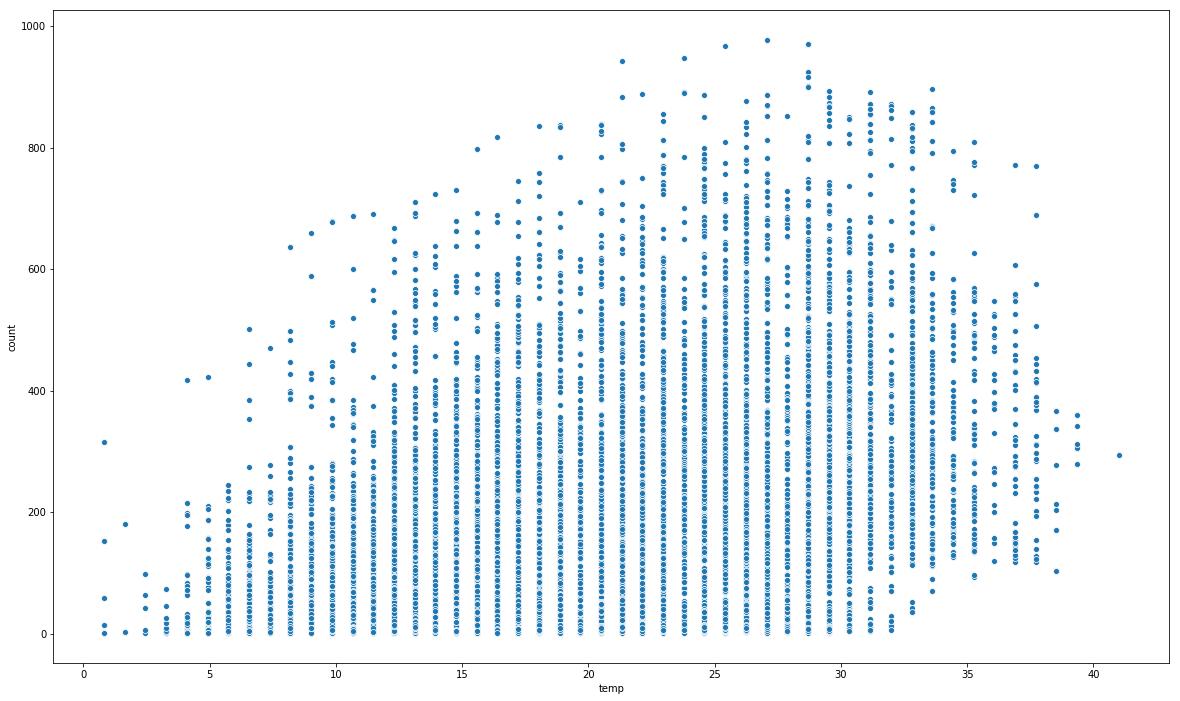

In [29]:
plt.figure(figsize=(20,12))
sns.scatterplot(x=train["temp"],y=train["count"])

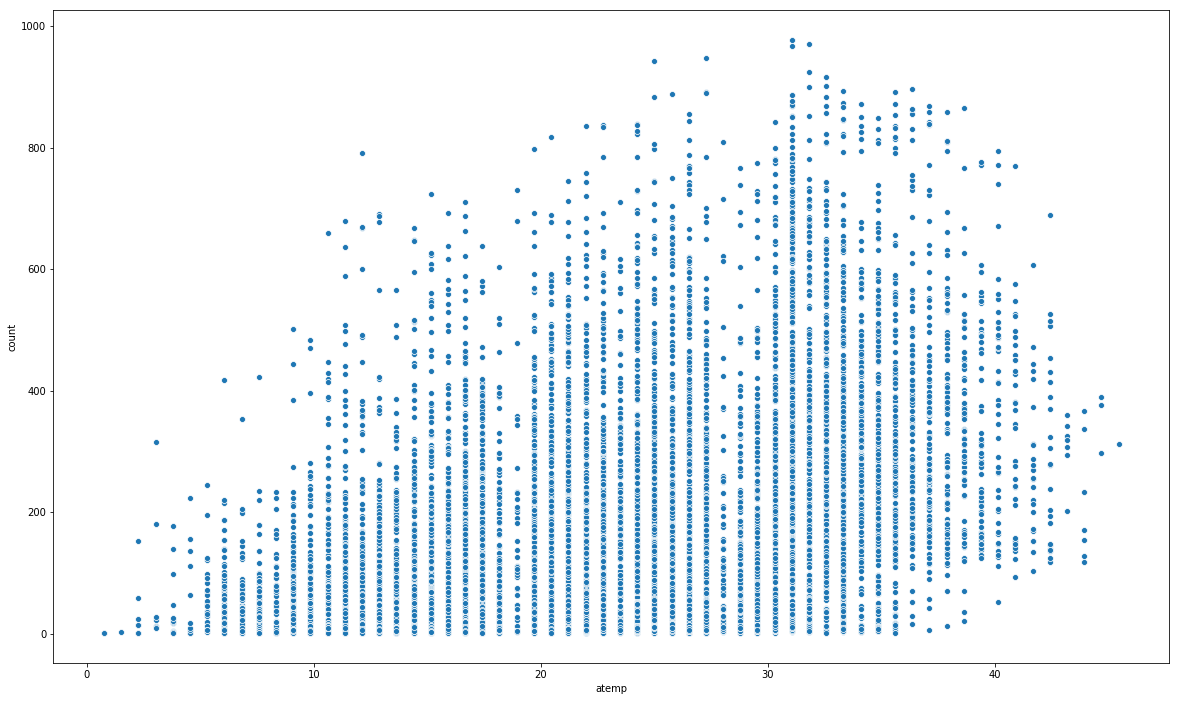

In [30]:
plt.figure(figsize=(20,12))
sns.scatterplot(x=train["atemp"],y=train["count"])

실제 온도와 체감온도는 분포에 거의 차이가 없다.

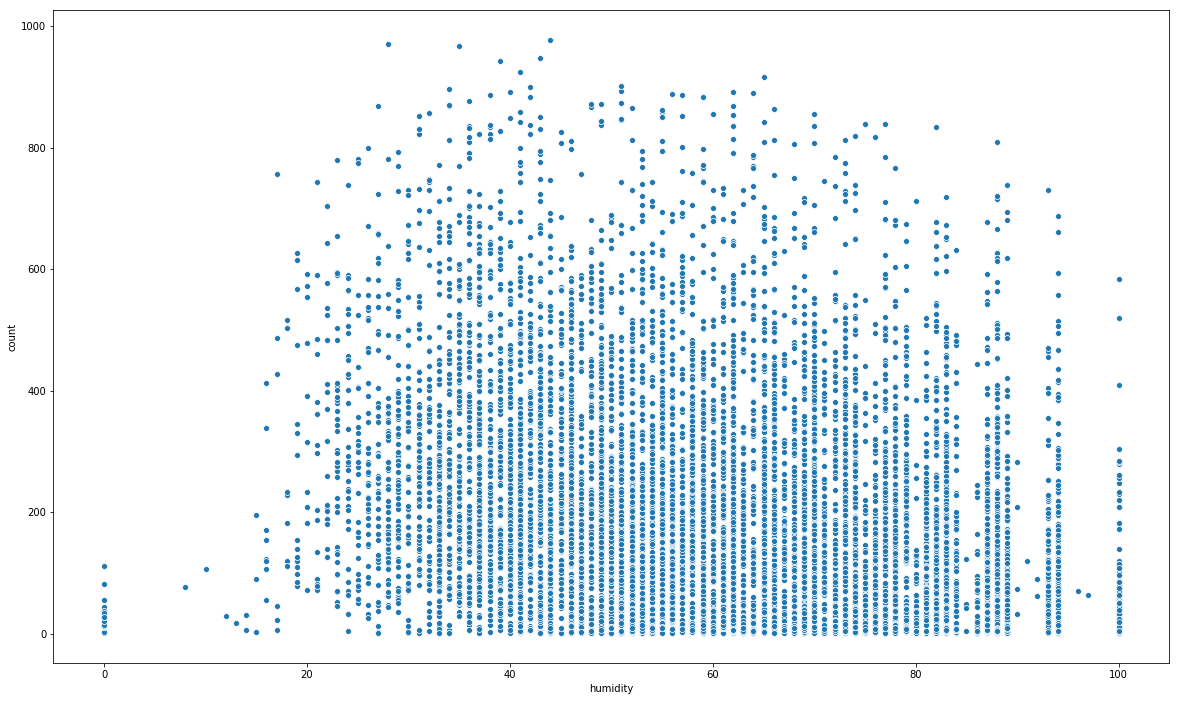

In [31]:
plt.figure(figsize=(20,12))
sns.scatterplot(x=train["humidity"],y=train["count"])

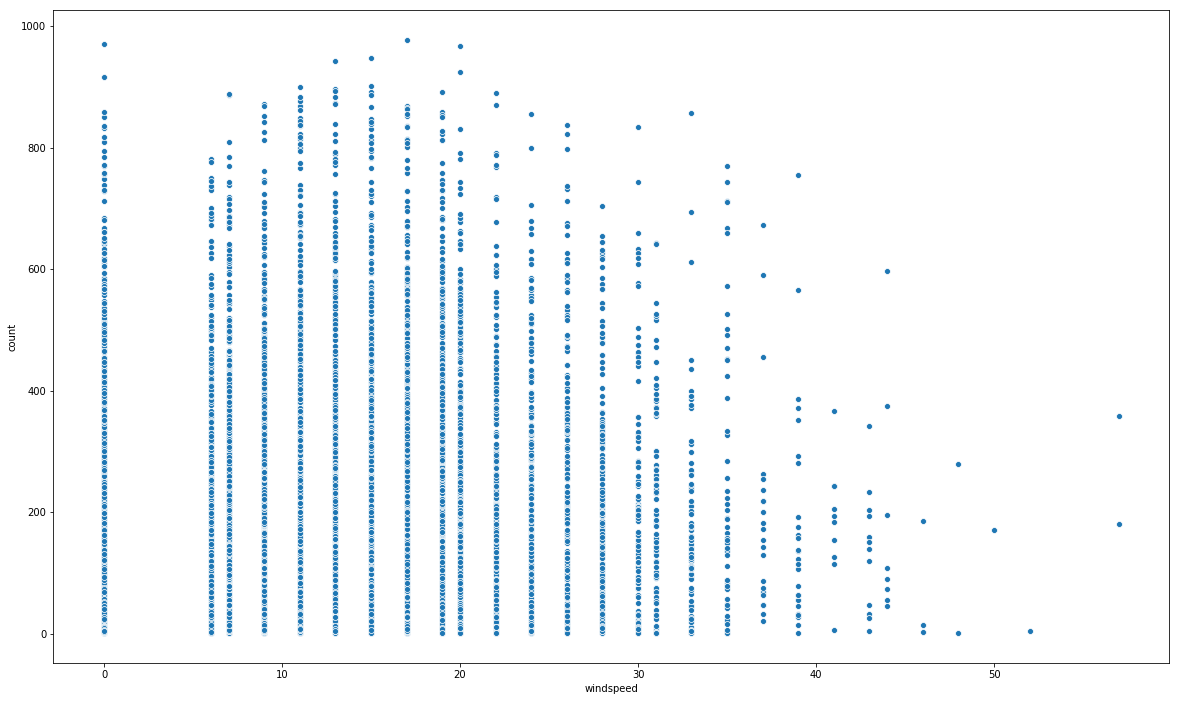

In [32]:
plt.figure(figsize=(20,12))
sns.scatterplot(x=train["windspeed"],y=train["count"])

풍속은 0에 많은 데이터가 있는 것으로 보아 누락된 값이 0으로 채워져있는 것으로 해석된다.

In [33]:
corr = train.corr()['count'].sort_values()

# Display correlations
print('상관계수:\n', corr)

상관계수:
 humidity     -0.317371
weather      -0.128655
holiday      -0.005393
weekday      -0.002283
workingday    0.011594
day           0.019826
windspeed     0.101369
season        0.163439
month         0.166862
year          0.260403
atemp         0.389784
temp          0.394454
hour          0.400601
casual        0.690414
registered    0.970948
count         1.000000
Name: count, dtype: float64


상관계수는 절대치가 클수록 결과에 영향이 크게 가기때문에 칼럼이 많을 경우 중요한 칼럼을 판별할 수 있다.

상관계수가 가장높은 2개는 Casual과 Registered이지만 이들은 비회원, 회원을 뜻하고 합치면 수요량이 되므로 상관관계가 높을 수 밖에 없다.

하지만 테스트 데이터에 없어 학습시킬 수 없다.

# <a id='3'><strong>Feature Engineering</strong></a>

### - Search for valid columns

In [34]:
train2 = train.drop(["datetime","casual","registered","count"],axis=1)

datetime는 년월일시 정보를 이미 추출했기 때문에 제외하고, casual, registered는 test에 없으므로 제외한다.

Count는 Target Label이고 test에 없으므로 제외한다.

In [35]:
train2.drop(["day","month"],axis=1,inplace=True)

day칼럼은 train과 test가진 day의 종류가 일치하지 않기 때문에 정확도에 악영향을 주고, Month칼럼 또한 day칼럼처럼 월 초의 데이터로 월 말의 데이터를 예측하는 것이 되므로 정확도에 악영향을 준다.

따라서 둘을 제거해야 한다.

In [36]:
train2.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,year,weekday
0,1,0,0,1,9.84,14.395,81,0.0,0,2011,5
1,1,0,0,1,9.02,13.635,80,0.0,1,2011,5
2,1,0,0,1,9.02,13.635,80,0.0,2,2011,5
3,1,0,0,1,9.84,14.395,75,0.0,3,2011,5
4,1,0,0,1,9.84,14.395,75,0.0,4,2011,5


In [37]:
test2 = test.drop(["datetime","day","month"],axis=1)
test2.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,year,weekday
0,1,0,1,1,10.66,11.365,56,26.0027,0,2011,3
1,1,0,1,1,10.66,13.635,56,0.0000,1,2011,3
2,1,0,1,1,10.66,13.635,56,0.0000,2,2011,3
3,1,0,1,1,10.66,12.880,56,11.0014,3,2011,3
4,1,0,1,1,10.66,12.880,56,11.0014,4,2011,3


### - Data preprocessing

모든 칼럼이 숫자형 데이터이고, 트리 모델을 사용하므로 특별한 encoding 기법은 사용하지 않은다. 

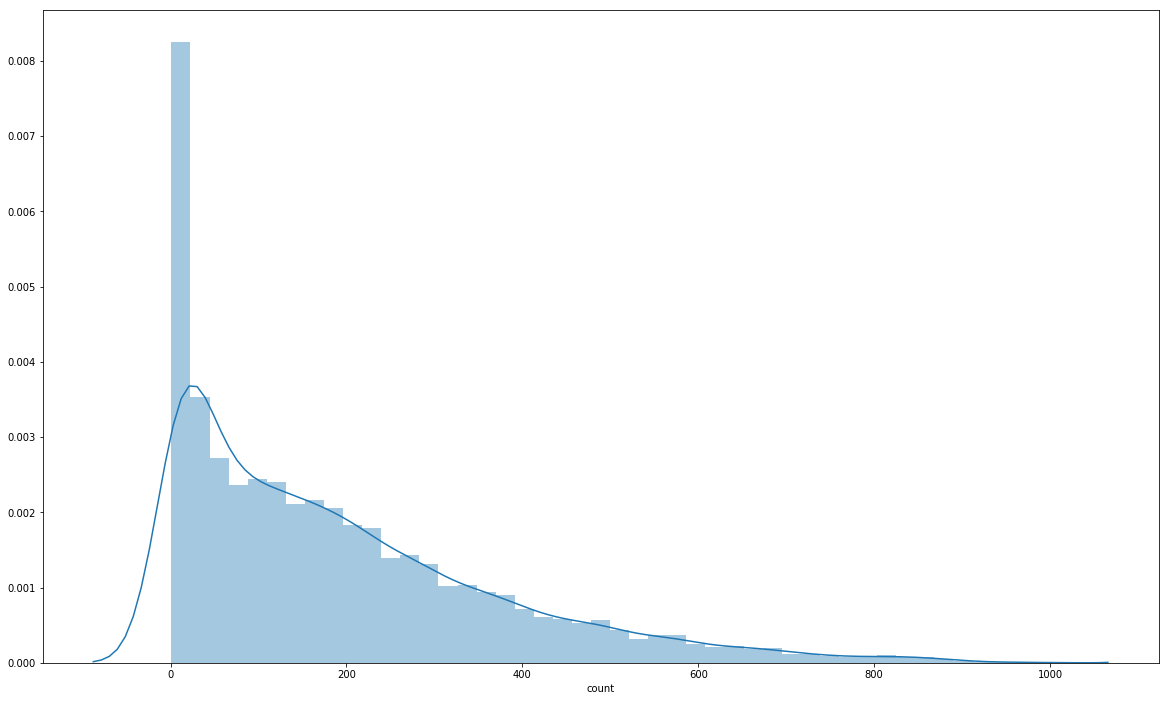

In [38]:
plt.figure(figsize=(20,12))
sns.distplot(train["count"])

다만 예측해야 할 카운트 값다만 예측해야 할 카운트 값의 Skewness(비대칭도)가 크므로 이를 해결해 주기 위해 Log 변환을 적용한다.

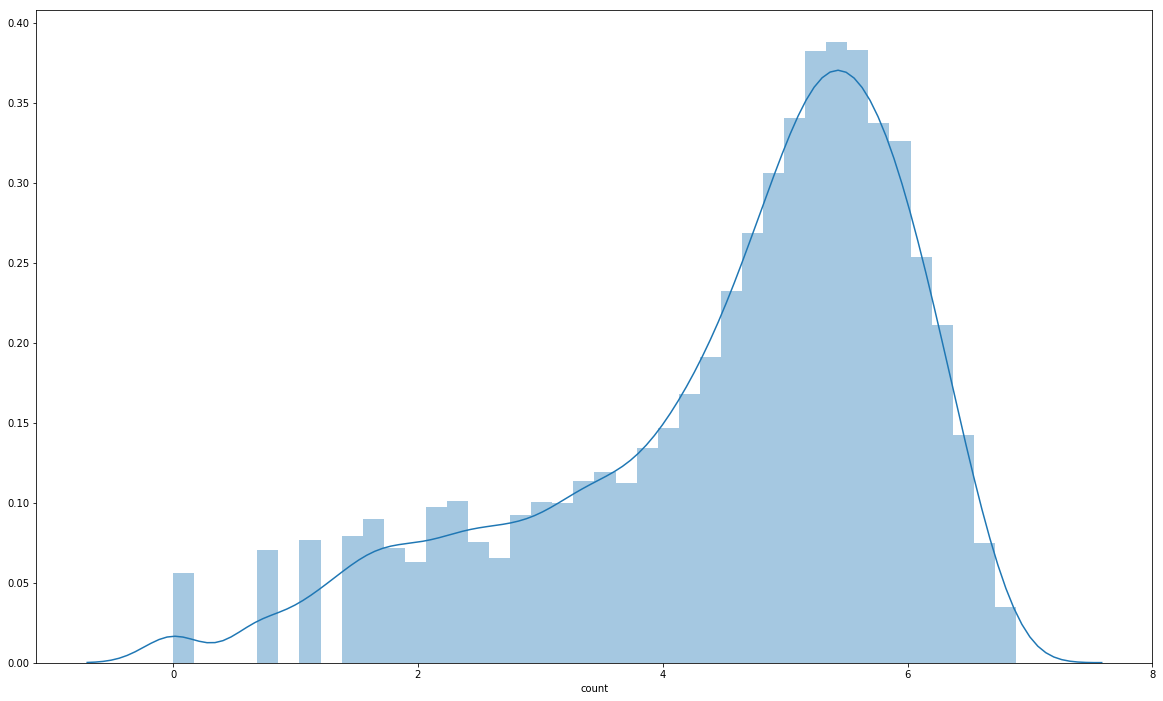

In [39]:
plt.figure(figsize=(20,12))
sns.distplot(np.log(train["count"]))

값의 분포가 완만해지고 정규분포에 가깝게 되었다.

# <a id='4'><strong>Modeling & make submission</strong></a>

### - RandomforestRegressor and LGBMRegressor

In [40]:
from sklearn.ensemble import RandomForestRegressor

model1 = RandomForestRegressor()
model1.fit(train2,np.log(train["count"]))
rf_result = model1.predict(test2)

#randomforest score = 0.394

In [41]:
pd.Series(model1.feature_importances_,index=train2.columns).sort_values(ascending=False)

hour          0.755057
temp          0.046770
workingday    0.039017
season        0.036357
year          0.031439
weekday       0.029357
humidity      0.020631
atemp         0.017694
windspeed     0.011039
weather       0.010991
holiday       0.001648
dtype: float64

feature_importances_ 를 이용하면 모델이 학습한 feature의 중요도를 확인할 수 있다.

In [42]:
from lightgbm import LGBMRegressor
model2 = LGBMRegressor() #no hyperparmeter tuning
model2.fit(train2,np.log(train["count"]))
lgbm_result = model2.predict(test2)

# LightGBM score  = 0.377

In [43]:
rf_result

array([2.42523628, 1.57767074, 0.9832592 , ..., 4.55054283, 4.58640346,
       3.82619008])

In [44]:
lgbm_result

array([2.32536909, 1.60189093, 1.08368173, ..., 4.68834583, 4.42383624,
       3.84273434])

In [45]:
test["count"] = lgbm_result
test.head(30)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,year,month,day,weekday,count
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,0,2011,1,20,3,2.325369
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,1,2011,1,20,3,1.601891
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2,2011,1,20,3,1.083682
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,3,2011,1,20,3,0.723929
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,4,2011,1,20,3,0.569841
5,2011-01-20 05:00:00,1,0,1,1,9.84,11.365,60,15.0013,5,2011,1,20,3,1.777248
6,2011-01-20 06:00:00,1,0,1,1,9.02,10.605,60,15.0013,6,2011,1,20,3,3.469687
7,2011-01-20 07:00:00,1,0,1,1,9.02,10.605,55,15.0013,7,2011,1,20,3,4.630527
8,2011-01-20 08:00:00,1,0,1,1,9.02,10.605,55,19.0012,8,2011,1,20,3,5.419932
9,2011-01-20 09:00:00,1,0,1,2,9.84,11.365,52,15.0013,9,2011,1,20,3,4.906130


### - Late Submission

In [46]:
sub = pd.read_csv("/kaggle/input/bike-sharing-demand/sampleSubmission.csv")
sub["count"] = np.exp(lgbm_result)
sub.head()

,datetime,count
0,2011-01-20 00:00:00,10.230455
1,2011-01-20 01:00:00,4.962407
2,2011-01-20 02:00:00,2.955541
3,2011-01-20 03:00:00,2.062522
4,2011-01-20 04:00:00,1.767986


In [47]:
sub.to_csv("sub.csv",index=False)